In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
import thesis_models

In [3]:
print(torch.__version__)

1.8.2


In [4]:
#Define File Path
# vec20avg_path = "./vec_data/vec20_avg.npz"
# vec25avg_path = "./vec_data/vec25_avg.npz"
vec30avg_path = "./vec_data/vec30_avg.npz"
# vec35avg_path = "./vec_data/vec35_avg.npz"
# vec20sum_path = "./vec_data/vec20_sum.npz"
# vec20sum_path = "./vec_data/vec20_sum.npz"
# vec25sum_path = "./vec_data/vec25_sum.npz"
vec30sum_path = "./vec_data/vec30_sum.npz"
# vec35sum_path = "./vec_data/vec35_sum.npz"
# freq_stance_labels = "./vec_data/freq_stance_labels.npz"
# oh_stance_labels = "./vec_data/oh_stance_labels.npz"
le_stance_labels = "./vec_data/le_stance_labels.npz"

In [5]:
def load_npz_file(filepath):
    # Load the numpy array from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
        for key in data.keys():
            arr = data[key]
            break
    return arr

In [6]:
# vec20avg = load_npz_file(vec20avg_path)
# vec25avg = load_npz_file(vec25avg_path)
vec30avg = load_npz_file(vec30avg_path)
# vec35avg = load_npz_file(vec35avg_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec25sum = load_npz_file(vec25sum_path)
vec30sum = load_npz_file(vec30sum_path)
# vec35sum = load_npz_file(vec35sum_path)
# freq_label = load_npz_file(freq_stance_labels)
# oh_label = load_npz_file(oh_stance_labels)
le_label = load_npz_file(le_stance_labels)

In [7]:
#指派實際要使用的Data與Label
# data = vec30avg
data = vec30sum
# label = np.argmax(oh_label, axis=1)
# label = oh_label
# label = freq_label
label = le_label

In [8]:
print(data.shape)
print(label.shape)
print(np.unique(label))
print(np.unique(label, return_counts=True))

(445, 1, 300)
(445,)
[0 1 2 3]
(array([0, 1, 2, 3]), array([ 11, 201,  74, 159], dtype=int64))


In [9]:
# Data Augmentation using Oversampling
# Define the oversampling ratio for each class
oversample_ratio = {0: 150, 1: 201, 2: 175, 3: 183}
# Initialize the oversampler
oversampler = RandomOverSampler(sampling_strategy=oversample_ratio)
# Reshape your data to a 2D matrix of shape (n_samples, n_features)
X = data.reshape(-1, 300)
# Apply oversampling to X and y
X_resampled, y_resampled = oversampler.fit_resample(X, label)
# Reshape X back to its original shape
X_resampled = X_resampled.reshape(-1, 1, 300)

In [10]:
print(X_resampled.shape)
print(X_resampled)

(709, 1, 300)
[[[-1.05289996 -1.29180002 10.12859917 ... -0.30050007  1.0638001
    0.92839986]]

 [[-0.92129999 -1.5751     10.76149985 ... -0.16209998  0.18860002
    1.30480001]]

 [[-1.47109997 -0.9589     12.55939994 ...  0.43750004  1.26569999
   -0.89280003]]

 ...

 [[-2.40010002 -1.0471     10.73909999 ... -0.24910002  2.14640003
   -0.19339997]]

 [[-1.07279999 -0.73840001 10.19399997 ... -0.88230002  1.81440001
    0.48010001]]

 [[-1.8784     -1.69869999  9.68190002 ... -2.60199996  2.50639998
    1.59430003]]]


In [11]:
print(y_resampled.shape)
print(y_resampled)

(709,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 2 1 2 1 2 1 2 2 1 2 2 2 1 1 2 1 1 1 1 1 2 1 1 2 2
 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 1 2 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2
 1 1 2 1 1 1 2 2 2 2 1 1 2 1 1 2 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1
 2 1 2 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0

In [12]:
# Convert NumPy arrays to PyTorch tensors-using oversampling
X_tensor = torch.from_numpy(X_resampled).float()
y_tensor = torch.from_numpy(y_resampled).long()

In [13]:
# Trainging Settings
input_size = 300  # Size of input vector
hidden_size = 64  # Number of features in the hidden state
num_layers = 2  # Number of LSTM layers
output_size = 4  # Number of output classes
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Epochs and records
num_epochs = 10
train_losses_list = []
val_losses_list = []
train_accuracies_list = []
val_accuracies_list = []

# # torchmetrcis settings
model_accuracy = MulticlassAccuracy(num_classes=4).to(device)
model_precision = MulticlassPrecision(num_classes=4).to(device)
model_recall = MulticlassRecall(num_classes=4).to(device)
model_f1 = MulticlassF1Score(num_classes=4).to(device)
model_ac_list = []
model_pc_list = []
model_rc_list = []
model_f1_list = []

# Define the number of folds for k-fold cross-validation
num_folds = 5
# Initialize the k-fold cross-validator
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

In [14]:
# Iterate over the folds and prepare data and labels for training and validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f'Fold {fold + 1}')
    X_train_fold = X_tensor[train_idx]
    y_train_fold = y_tensor[train_idx]
    X_val_fold = X_tensor[val_idx]
    y_val_fold = y_tensor[val_idx]

    # Create PyTorch DataLoader for training and validation
    train_data = TensorDataset(X_train_fold, y_train_fold)
    val_data = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    # Initialize the reocrd lists for this fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early Stopping Settings
    patience = 3
    counter = 0
    best_val_accuracy = 0.0

    # Instantiate the model
    model = thesis_models.LSTM_0(input_size, hidden_size, num_layers, output_size)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      train_correct = 0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target.squeeze().long()).sum().item()
        # train_correct += torch.sum(predicted == target.data)
      train_loss /= len(train_loader)
      train_accuracy = 100.0 * train_correct / len(train_data)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Evaluate the model on the validation set
      model.eval()
      val_loss = 0.0
      val_correct = 0
      with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
          data = data.to(device)
          target = target.to(device)
          output = model(data)
          loss = criterion(output, target)
          val_loss += loss.item()
          # val_loss += loss.item() * data.size(0)
          _, predicted = torch.max(output.data, 1)
          val_correct += (predicted == target.squeeze().long()).sum().item()
          # val_correct += torch.sum(predicted == target.data)
          model_accuracy.update(predicted, target.squeeze().long())
          model_precision.update(predicted, target.squeeze().long())
          model_recall.update(predicted, target.squeeze().long())
          model_f1.update(predicted, target.squeeze().long())
      val_loss /= len(test_loader)
      val_accuracy = 100.0 * val_correct / len(val_data)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print('Epoch: {} \tTrain Loss: {:.6f} \tTrain Accuracy: {:.2f}% \tVal Loss: {:.6f} \tVal Accuracy: {:.2f}%'.format(
          epoch, train_loss, train_accuracy, val_loss, val_accuracy))
      
      if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
      else:
        counter += 1
        if counter >= patience:
          print("Early stopping at epoch", epoch)
          break
        
    # Append the lists for this fold to the corresponding list for all folds
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_accuracies_list.append(train_accuracies)
    val_accuracies_list.append(val_accuracies)
    ac = model_accuracy.compute()
    pc = model_precision.compute()
    rc = model_recall.compute()
    f1 = model_f1.compute()
    model_ac_list.append(ac.item())
    model_pc_list.append(pc.item())
    model_rc_list.append(rc.item())
    model_f1_list.append(f1.item())

Fold 1
Epoch: 0 	Train Loss: 1.330376 	Train Accuracy: 41.80% 	Val Loss: 1.231617 	Val Accuracy: 71.83%
Epoch: 1 	Train Loss: 1.088795 	Train Accuracy: 76.54% 	Val Loss: 0.931445 	Val Accuracy: 83.10%
Epoch: 2 	Train Loss: 0.786459 	Train Accuracy: 80.07% 	Val Loss: 0.673253 	Val Accuracy: 80.28%
Epoch: 3 	Train Loss: 0.529627 	Train Accuracy: 85.71% 	Val Loss: 0.449227 	Val Accuracy: 88.73%
Epoch: 4 	Train Loss: 0.351758 	Train Accuracy: 89.24% 	Val Loss: 0.339362 	Val Accuracy: 88.73%
Epoch: 5 	Train Loss: 0.238999 	Train Accuracy: 94.00% 	Val Loss: 0.273745 	Val Accuracy: 90.85%
Epoch: 6 	Train Loss: 0.164611 	Train Accuracy: 96.47% 	Val Loss: 0.237723 	Val Accuracy: 92.96%
Epoch: 7 	Train Loss: 0.115103 	Train Accuracy: 97.53% 	Val Loss: 0.221581 	Val Accuracy: 94.37%
Epoch: 8 	Train Loss: 0.077544 	Train Accuracy: 98.59% 	Val Loss: 0.206790 	Val Accuracy: 92.96%
Epoch: 9 	Train Loss: 0.054393 	Train Accuracy: 99.29% 	Val Loss: 0.206472 	Val Accuracy: 93.66%
Fold 2
Epoch: 0 	Train 

In [15]:
print(len(train_losses_list))
print(len(train_losses_list[0]))

5
10


In [16]:
print(model_f1_list)

[0.8852713108062744, 0.8479453325271606, 0.8448789119720459, 0.8512167930603027, 0.8456741571426392]


In [17]:
avg_train_losses = [sum(x)/len(x) for x in zip(*train_losses_list)]
avg_val_losses = [sum(x)/len(x) for x in zip(*val_losses_list)]
avg_train_accuracies = [sum(x)/len(x) for x in zip(*train_accuracies_list)]
avg_val_accuracies = [sum(x)/len(x) for x in zip(*val_accuracies_list)]

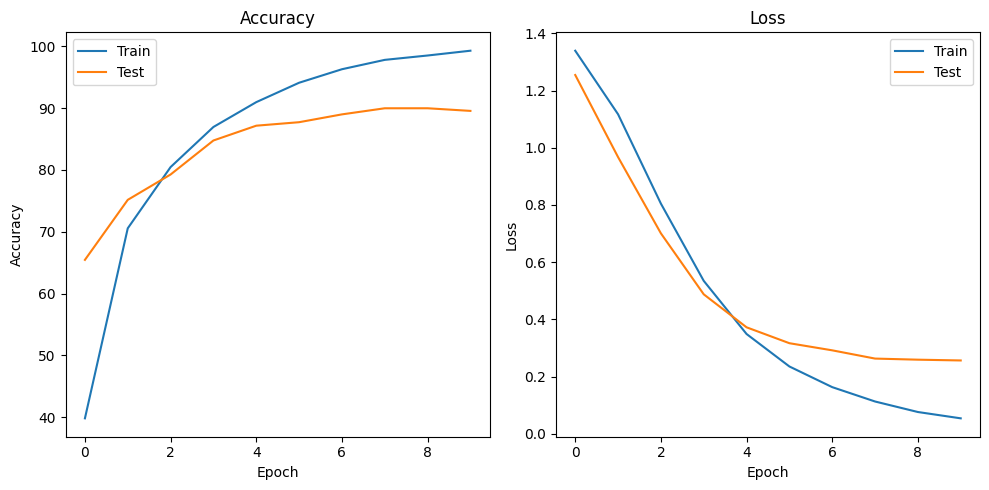

In [18]:
# Plot the train and test accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(avg_train_accuracies, label='Train')
ax1.plot(avg_val_accuracies, label='Test')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(avg_train_losses, label='Train')
ax2.plot(avg_val_losses, label='Test')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
# plt.savefig('vec30_sum_cnn1_230419.PNG', dpi=300)
plt.show()

In [19]:
print(round(avg_train_accuracies[-1], 2))
print(round(avg_val_accuracies[-1], 2))
print(round(avg_train_losses[-1], 2))
print(round(avg_val_losses[-1], 2))

99.29
89.56
0.05
0.26


In [20]:
Avg_ac = sum(model_ac_list)/len(model_ac_list)
Avg_pc = sum(model_pc_list)/len(model_pc_list)
Avg_rc = sum(model_rc_list)/len(model_rc_list)
Avg_f1 = sum(model_f1_list)/len(model_f1_list)

print('Avg Model Accuracy: {:.2%}'.format(Avg_ac))
print('Avg Model Precision: {:.2%}'.format(Avg_pc))
print('Avg Model Recall: {:.2%}'.format(Avg_rc))
print('Avg Model F1-score: {:.2%}'.format(Avg_f1))

Avg Model Accuracy: 85.49%
Avg Model Precision: 85.57%
Avg Model Recall: 85.49%
Avg Model F1-score: 85.50%


In [ ]:
# #Save Model Parameter
# torch.save(model, 'cnn_vec30sum.pt')